In [1]:
import Pkg
Pkg.activate(@__DIR__)

  Activating environment at `~/all_about_robotics/julia_optimisation_course/tutorial/Project.toml`


In [2]:
using ControlSystemsBase
using LinearAlgebra
using Plots
import ForwardDiff as FD

[ Info: Precompiling ControlSystemsBase [aaaaaaaa-a6ca-5380-bf3e-84a91bcd477e]


In [3]:
# define the feedback linearized model of the simple pendulum
m=1    # mass is of the pendulum
g=9.81 # gravity
l=1 # length of the pendulum

h=0.001 # time step for rk45 integrator

# actual dynamics
function dynamics(x,τ)
     x1,x2=x
    x1_dot= x2
    x2_dot= -(g / l)*sin(x1)+(τ / (m*l^2))
    return [x1_dot;x2_dot]
end
    

dynamics (generic function with 1 method)

In [4]:
function rk45step(x,τ_v)
  f1=dynamics(x,τ_v)
   f2=dynamics(x+0.5*h*f1,τ_v)
   f3=dynamics(x+0.5*h*f2,τ_v)
   f4=dynamics(x+h*f3,τ_v)
    
   return x+(h/6)*(f1+2*f2+2*f3+f4)
    
end

rk45step (generic function with 1 method)

In [5]:
function rk45_solve(t0, x0, tf)
    t = t0
    x = x0
        
    ts = [t] # vector to save time steps
    xs = [x0] # vector to save state trajectory
    
    while t < tf
        x_new = rk45step(x,0)
        t += h
        x = x_new
        push!(ts, t)
        push!(xs, x)
    end
    
    return ts, xs
end

rk45_solve (generic function with 1 method)

In [6]:

x0=[pi-0.001, 0.0]
dynamics
# Time span
t0 = 0.0
tf = 100.0
t_vals, x_vals = rk45_solve(t0,x0,tf)

# Extract angle values
θ_vals = [x[1] for x in x_vals]
w_vals=[x[2] for x in x_vals]
# Plot the results
plot(t_ [1] dynamicrk45steps(x::Vector{Float64}, τ::Int64)
vals, θ_vals, label="Angle", xlabel="Time", ylabel="Angle", legend=true)
plot!(t_vals, w_vals, label="omega", xlabel="Time", ylabel="omega", legend=true,show=true)

LoadError: syntax: space before "[" not allowed in "t_ [" at In[6]:13

In [36]:
#linearize the non linear dynamics

A=FD.jacobian(x->dynamics(x,0),[0,0])
B=FD.derivative(x->dynamics([0,0],x),0)

nx=2
nu=1

H = exp([A B; zeros(nu, nx + nu)]*h)
Ad = H[1:nx,1:nx] # TODO
Bd = H[1:nx,(nx+1):(nx+nu)] # TODO

#weight matrices of cost function
Q=diagm([100,1])
R=I

K=lqr(Discrete,Ad,Bd,Q,R)

@show size(K)

#simulate and the control 
xref=[0,0]
x0=[pi/2,0]

#problem size
tf=5
t_vec=0:h:tf
N=length(t_vec)

#states 
X=[zeros(nx) for i=1:N]
X[1]=x0

size(K) = (1, 2)


2-element Vector{Float64}:
 1.5707963267948966
 0.0

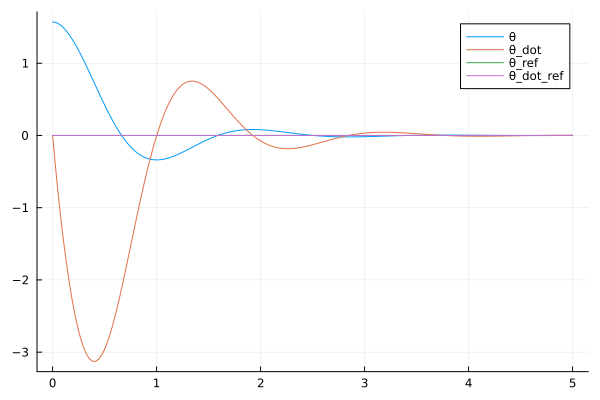

In [37]:
 for i = 1:N-1
        # TODO: use your FHLQR control gains K to calculate u_lqr
        # simulate lqr control 
        u_lqr = -K*(X[i]-xref)
        #feedback linearized
        X[i+1]=rk45step(X[i],u_lqr[1])
      
end

size(X)
    
Xm = hcat(X...)



plot(t_vec,Xm[1,:],label="θ")
plot!(t_vec,Xm[2,:],label="θ_dot")

#plot the reference values

x_ref_vec = repeat(xref, 1, N)
plot!(t_vec,x_ref_vec[1,:],label="θ_ref")
plot!(t_vec,x_ref_vec[2,:],label="θ_dot_ref")




In [24]:
# LQR for feedback linearised model

A=[0 1;0 0]
B=[0;1]

nx=2
nu=1

H = exp([A B; zeros(nu, nx + nu)]*h)
Ad = H[1:nx,1:nx] # TODO
Bd = H[1:nx,(nx+1):(nx+nu)] # TODO

#weight matrices of cost function
Q=diagm([10,10])
R=I

K=lqr(Discrete,Ad,Bd,Q,R)

#simulate and the control 
xref=[pi/2,0]
x0=[0,0]

#problem size
tf=5
t_vec=0:h:tf
N=length(t_vec)

#states 
X=[zeros(nx) for i=1:N]
X[1]=x0


2-element Vector{Int64}:
 0
 0

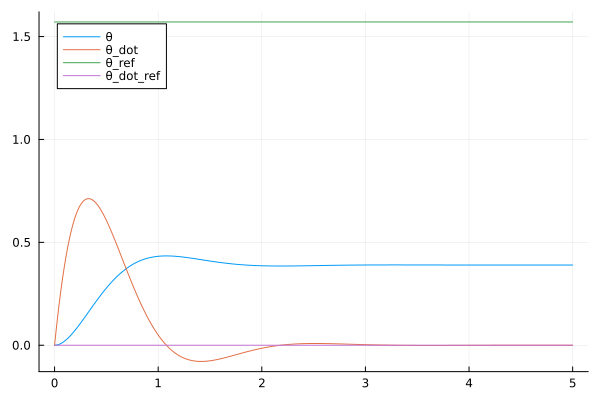

In [26]:
 for i = 1:N-1
        # TODO: use your FHLQR control gains K to calculate u_lqr
        # simulate lqr control 
        u_lqr = -K*(X[i]-xref)
        # adjust the input to cancel the non linear part of the dynamics
        τ= m*g*l*sin(X[1][1])+m*l*l*u_lqr[1]
        #feedback linearized
        X[i+1]=rk45step(X[i],τ)
      
end
    
Xm = hcat(X...)



plot(t_vec,Xm[1,:],label="θ")
plot!(t_vec,Xm[2,:],label="θ_dot")

#plot the reference values

x_ref_vec = repeat(xref, 1, N)
plot!(t_vec,x_ref_vec[1,:],label="θ_ref")
plot!(t_vec,x_ref_vec[2,:],label="θ_dot_ref")
